In [1]:
using PyPlot, DualNumbers

In [2]:
"""
    ciclosestables!(xx, f, nit, nout, cc)

Esta función itera el mapeo `f`, de una variable, `nit+nout` veces, 
usando como condición inicial `x0=0`; los últimos `nout` iterados 
actualizan al vector `xx` que tiene longitud `nout`. `cc` es el valor
del parámetro del mapeo `f`. El mapeo `f` debe ser definido de 
tal manera que `f(x0,cc)` tenga sentido. La idea es los últimos 
`nout` iterados reflejen los ciclos estables del mapeo `f`. 
"""
function ciclosestables!(xx, f, nit, nout, cc)
    @assert nit > 0 && nout > 0
    
    # Primeros nit iterados
    x0 = 0.0
    for it = 1:nit
        x0 = f(x0, cc)
    end
    
    # Se guardan los siguientes nout iterados
    for it = 1:nout
        x0 = f(x0, cc)
        @inbounds xx[it] = x0
    end
    
    return nothing
end

"""
    diagbifurc(f, nit, nout, crange)

Itera el mapeo `f` `nit+nout` veces y regresa una matriz
cuya columna `i` tiene los últimos `nout` iterados del mapeo
para el valor del parámetro del mapeo `crange[i]`.

La función `f` debe ser definida de tal manera que `f(x0, c)` 
tenga sentido.
"""
function diagbifurc(f, nit, nout, crange)
    xx = Vector{Float64}(nout)
    ff = Array{Float64,2}(nout, length(crange))
    
    for ic in eachindex(crange)
        c = crange[ic]
        ciclosestables!(xx, f, nit, nout, c)
        
        
        ff[:,ic] = xx
        
    end
    
    return ff
end

diagbifurc (generic function with 1 method)

In [3]:
Qc(x,c) = x^2 + c

crange = 0.25:-1/2^10:-1.0

ff = diagbifurc(Qc, 1000, 256, crange); 
cc = ones(size(ff)[1])*crange';

# Esto cambia las matrices en vectores; ayuda un poco para los dibujos
ff = reshape(ff, size(ff)[1]*size(ff)[2]);
cc = reshape(cc, size(ff));

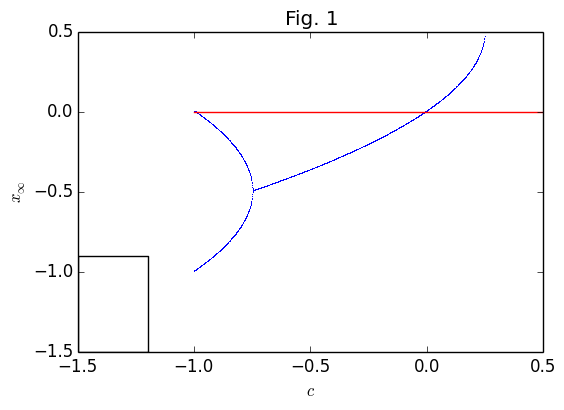

PyObject <matplotlib.text.Text object at 0x31a04f910>

In [4]:
figure(figsize=(6,4))
plot(cc, ff, "b,")
plot([-1.2,-1.5,-1.5,-1.2,-1.2],[-1.5,-1.5,-0.9,-0.9,-1.5], "k-")
plot([-1,0.5],[0.0,0.0], "r-")
xlabel(L"c")
ylabel(L"x_\infty")
title("Fig. 1")

-----

In [5]:
Qc(x,c) = x^2 + c

crange = 0.25:-1/2^10:-1.0

f1 = diagbifurc(Qc, 10000, 2, crange); 
c1 = ones(size(ff)[1])*crange';

In [6]:
function find_one_bif(ff, cc)

    Resta = []
    bif = 0

    for i in 1:length(ff[1,:])

        resta = abs(ff[1, i] - ff[2, i])

        if resta > 0.0001

            bif = i
            break

        end

    end

    bif, cc[1, bif]

end

find_one_bif (generic function with 1 method)

In [7]:
find_one_bif(f1, c1) #funciona! Aunque está bien chafa.

(1025,-0.75)

#### voy a tratar de refinar las orbitas usando métdo de newton

Es necesario tener una función que te genera la función iterada en sí misma. Entonces...

### Metaprogramming (cuadrica y más allá...)

In [8]:
nombre(n::Int) = symbol( string("F_", n) )

nombre (generic function with 1 method)

In [9]:
function itera_funcion_identidad(n)
    
    x = "x^2 + c"

    for i in 1:n-1

        x = "($x)^2 +c - x"

    end

    ex = parse(x)
    ex_ret = :( $(nombre(n))(x, c) = $ex )
    ex_ret
end 

itera_funcion_identidad (generic function with 1 method)

Funciona con `DualNumbers` y está muy chido!

### Adecuando `compute_roots`

Lo que busco es darle de comer las orbitas de la función de arriba para que la refine

In [61]:
"""
    compute_roots(f::Function, xx, c)
    Out: roots

xx is an array, cc is the parameter, f is the funtion

"""
function compute_roots(f::Function, xx, c)
    
    roots = similar(xx)

    for j in 1:length(xx)
        
        x = Dual(xx[j], xx[j])

        # 100 iterations of Newton's method
        for i in 1:100
            x_2 = realpart(x) - realpart(f(x, c)) / dualpart(f(x, c))
            x = Dual(x_2, x_2)
        end

        roots[j] = realpart(x)
    end
    
    roots
end

compute_roots (generic function with 1 method)

In [38]:
Qc(x,c) = x^2 + c

crange = -0.75:-1/2^10:-1.0

f1 = diagbifurc(Qc, 10000, 100, crange); 
c1 = ones(size(ff)[1])*crange';

In [39]:
f1[:,1][2]

-0.49290999218222853

In [40]:
eval(itera_funcion_identidad(2))

F_2 (generic function with 1 method)

In [41]:
compute_roots(F_2, f1[:, 3], c1[:,3])

100-element Array{Float64,1}:
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
  ⋮       
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
 -0.455806

In [42]:
c1[:,3]

a = f1[:, 3]

100-element Array{Float64,1}:
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
  ⋮       
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
 -0.455806
 -0.544194
 -0.455806

In [16]:
for j in 1:length(a)

    for i in 1:length(a)
    
        if i == j
            
            nothing
            
        elseif a[i] == a[j]
            
            a[i] = NaN
        end
    end
end

a

100-element Array{Float64,1}:
  -0.544194
  -0.455806
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
   ⋮       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       
 NaN       

In [17]:
deleteat!(a,find(isnan, a))

2-element Array{Float64,1}:
 -0.544194
 -0.455806

In [18]:
A = [NaN 2 3; 4 5 6; 7 8 9]

3x3 Array{Float64,2}:
 NaN    2.0  3.0
   4.0  5.0  6.0
   7.0  8.0  9.0

In [19]:
A[1, 2] = NaN

A[3,3] = NaN

A[2,3] = NaN

A[1,3] = NaN

NaN

In [20]:
function delete_equals(A)

    for j  in 1:length(A)
        for i  in 1:length(A)

            if i == j
                
                nothing

            elseif A[i] == A[j]

                A[i] = NaN
            end
        end
    end
    
    A #deleteat!(A,find(isnan, A))
    
end

delete_equals (generic function with 1 method)

# Ahora integro todo lo que hice arriba al método de Luis

Pasos para acomplar las funciones:
1. `diagbifuc`: se crea una matriz con las orbitas de las iteraciones.
2. `computeroots`: refinamos las orbitas.
    - itera_funcion
    - Condiciones para aplicar la cuádrica.
    
3. Ver si poner los datos en una matriz o en un array.

--------

In [76]:
workspace()

In [78]:
using Plots, PlotRecipes, LaTeXStrings, DualNumbers
pyplot()

Plots.PyPlotBackend()

In [101]:
include("itera_funcion.jl")

cobweb_plot! (generic function with 1 method)

In [116]:
for i in 1:3

    eval(itera_funcion(i))
    
end

In [117]:
f1(x) = F_1(x, -1.0)
f2(x) = F_2(x, -1.0)
f3(x) = F_3(x, -1.0)

f3 (generic function with 1 method)

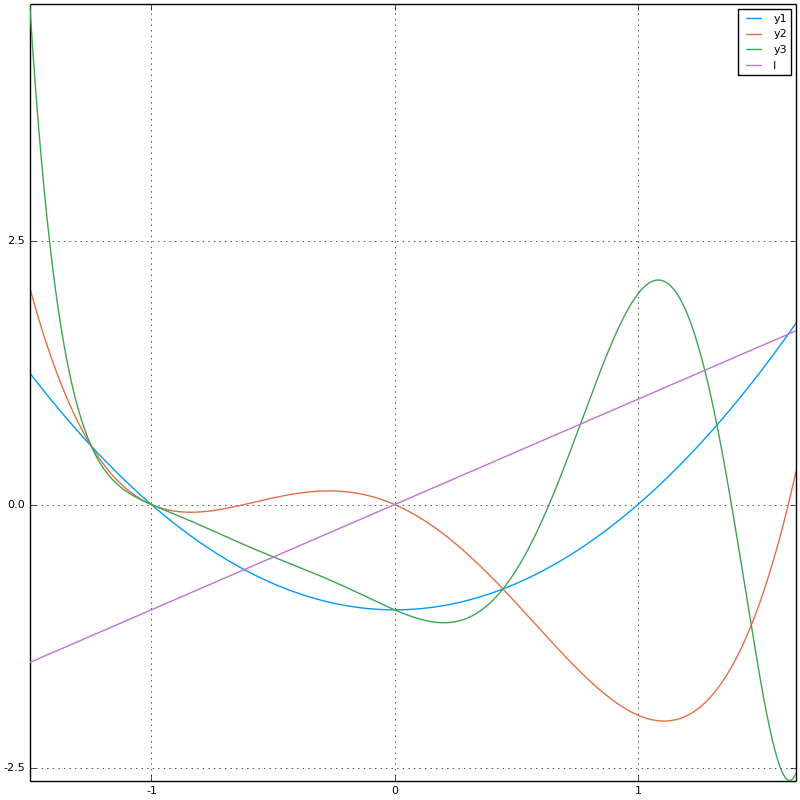

In [129]:
rango = -1.5:0.001:1.65
plot(rango, f1, size=(800, 800))
plot!(rango, f2)
plot!(rango, f3)
plot!(rango, identity, label=("I"))

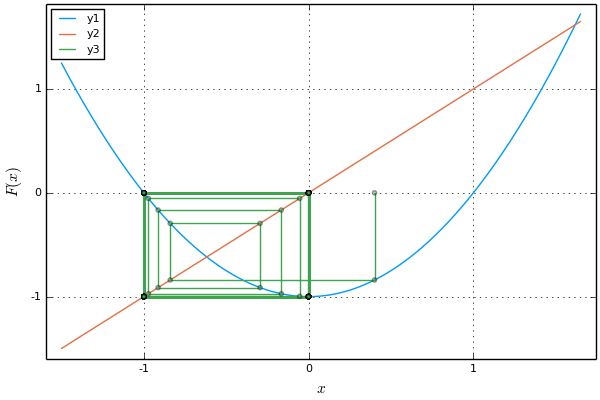

In [134]:
cobweb_plot(f1, 0.4, rango, 100)

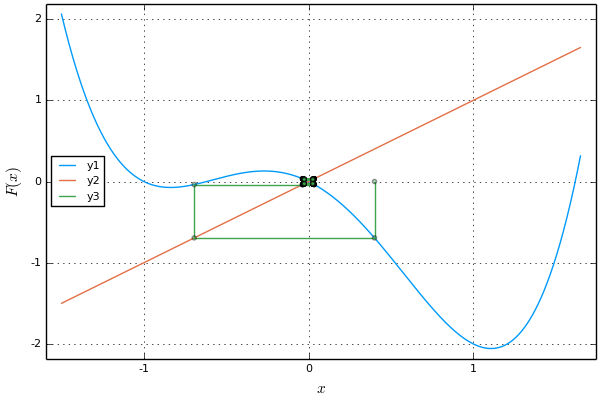

In [135]:
cobweb_plot(f2, 0.4, rango, 100)

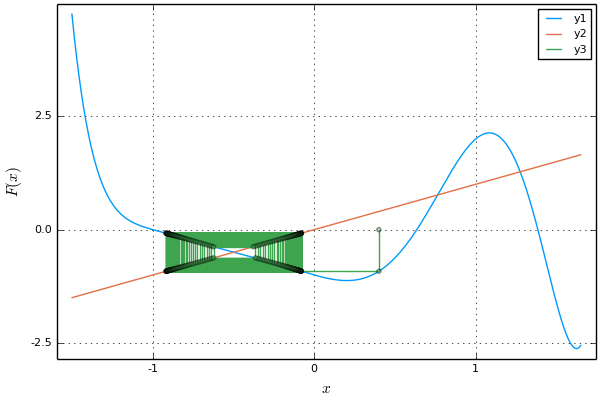

In [140]:
cobweb_plot(f3, 0.4, rango, 100)